Found 1097 files belonging to 3 classes.
Using 878 files for training.
Found 1097 files belonging to 3 classes.
Using 219 files for validation.
 Train: 878
 Val: 219
 Class weights: {0: 2.9562289562289563, 1: 0.644640234948605, 2: 0.9005128205128206}
Epoch 1/40
28/28 [==============================] - 15s 226ms/step - loss: 0.8902 - accuracy: 0.5900 - val_loss: 0.6973 - val_accuracy: 0.7306
Epoch 2/40
28/28 [==============================] - 7s 251ms/step - loss: 0.6546 - accuracy: 0.7745 - val_loss: 0.6328 - val_accuracy: 0.7489
Epoch 3/40
28/28 [==============================] - 7s 249ms/step - loss: 0.5463 - accuracy: 0.8166 - val_loss: 0.6799 - val_accuracy: 0.7306
Epoch 4/40
28/28 [==============================] - 7s 248ms/step - loss: 0.5271 - accuracy: 0.8246 - val_loss: 0.7228 - val_accuracy: 0.7260
Epoch 5/40
28/28 [==============================] - 7s 250ms/step - loss: 0.4872 - accuracy: 0.8212 - val_loss: 0.6817 - val_accuracy: 0.7397
Epoch 6/40
28/28 [====================

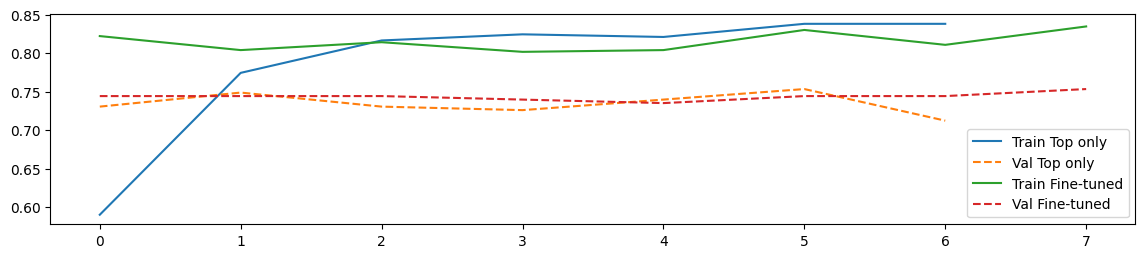

 Model salvat cu succes în formatul Keras.
1/1 [==============================] - 1s 680ms/step

 Classification Report:
                 precision    recall  f1-score   support

   Bengin cases       0.12      0.14      0.13        21
Malignant cases       0.99      0.67      0.80       107
   Normal cases       0.73      0.97      0.83        91

       accuracy                           0.74       219
      macro avg       0.61      0.59      0.59       219
   weighted avg       0.80      0.74      0.75       219



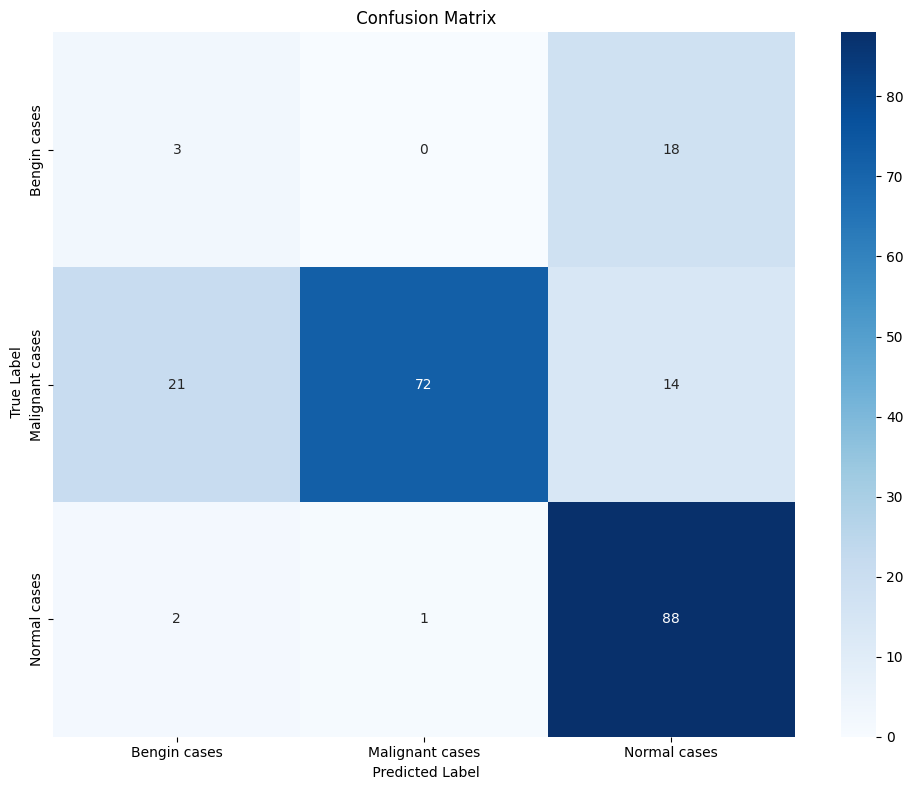

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.applications import EfficientNetB0, efficientnet
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

#  Setari
IMG_SIZE = (224,224)
BATCH_SIZE = 32
EPOCHS_TOP = 40
EPOCHS_FINE = 40
SEED=42
DATASET_PATH=r"C:\Users\Luchi\Desktop\LicentaCompleta\Imagini\TrainImages"
AUTOTUNE = tf.data.AUTOTUNE

#  Incarcare date
train_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH, validation_split=0.2, subset="training", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH, validation_split=0.2, subset="validation", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE
)
class_names = train_ds.class_names
num_classes = len(class_names)

#  Numarare imagini
print(" Train:", sum(len(x) for x, _ in train_ds))
print(" Val:", sum(len(x) for x, _ in val_ds))

#  Class weights
y = np.concatenate([y.numpy() for _, y in train_ds])
cw_values = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
cw = {int(i): float(w) for i, w in enumerate(cw_values)}  # convertim la float
print(" Class weights:", cw)

#  Augmentare
data_aug = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x,y: (data_aug(x), y)).prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)

#  Creare model EfficientNetB0
base = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(*IMG_SIZE,3))
base.trainable = False  # freeze

inputs = Input(shape=(*IMG_SIZE,3))
x = efficientnet.preprocess_input(inputs)  # normalize corect
x = base(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#  Callback
es = EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss')

#  Antrenament Top 1
history_top = model.fit(train_ds, validation_data=val_ds,
                        epochs=EPOCHS_TOP, class_weight=cw, callbacks=[es])

#  Fine tuning: deblocare straturi superioare
base.trainable = True
fine_at = len(base.layers) - 20
for layer in base.layers[:fine_at]:
    layer.trainable = False
for layer in base.layers[fine_at:]:
    layer.trainable = True

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(train_ds, validation_data=val_ds,
                         epochs=EPOCHS_FINE, class_weight=cw, callbacks=[es])

#  Plot
def plot(hs, labs):
    plt.figure(figsize=(14,6))
    for i,(h,l) in enumerate(zip(hs,labs)):
        plt.subplot(2,1,1 if i<2 else 2)
        plt.plot(h.history['accuracy'], label=f"Train {l}")
        plt.plot(h.history['val_accuracy'], '--', label=f"Val {l}")
        plt.legend()
    plt.show()

plot([history_top, history_fine], ["Top only", "Fine-tuned"])

try:
    model.save("EN_model.keras", save_format="keras")
    print(" Model salvat cu succes în formatul Keras.")
except TypeError as e:
    print(" Eroare la salvare completa:", e)
    print(" Salvam separat arhitectura si greutatile (fallback).")

    #  Salvare fallback (arhitectură + greutăți)
    model_json = model.to_json()
    with open("EN_model_architecture.json", "w") as json_file:
        json_file.write(model_json)

    model.save_weights("EN_model_weights.h5")
    print(" Arhitectură și greutăți salvate separat.")

#  Etichete si predictii
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

#  Raport clasificare
print("\n Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

#  Matrice de confuzie
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel(" Predicted Label")
plt.ylabel(" True Label")
plt.title(" Confusion Matrix")
plt.tight_layout()
plt.show()
